## Ignition delay simulation of complete n-c10 RMG model

In [1]:
import sys
sys.path.append('/scratch/ajulu.c/anaconda3/envs/rmg_py3')

In [2]:
!which python
# !conda list rmg_py3

/scratch/ajulu.c/anaconda3/envs/rmg_py3/bin/python


In [3]:
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

ct.__version__

'2.4.0'

In [4]:
# from cantera import ck2cti

# ck2cti.main([
#     '--input=/scratch/ajulu.c/Code/GTL/nc10/nc10_lowT/chemkin/chem.inp',
#     '--tran=/scratch/ajulu.c/Code/GTL/nc10/nc10_lowT/chemkin/tran.dat',
#     '--output=/scratch/ajulu.c/Code/GTL/nc10/nc10_lowT/chemkin/chem.cti',
#     '--permissive'])

In [7]:
gas = ct.Solution('/scratch/ajulu.c/Code/GTL/nc10/chem_annotated.cti')



**** WARNING ****
For species HOCHO(370), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [8]:
print(len(gas.species()), len(gas.reactions()))

628 24462


In [9]:
sorted(gas.species_names)

['Ar',
 'C(53)',
 'C10H20(51)',
 'C10H21(50)',
 'C2(366)',
 'C2H(4)',
 'C2H2(42)',
 'C2H3(44)',
 'C2H3O(365)',
 'C2H4(11)',
 'C2H4O(359)',
 'C2H4O(74)',
 'C2H5(38)',
 'C2H5O(357)',
 'C2H5O(360)',
 'C2H5O(368)',
 'C2H6(23)',
 'C2H6O(367)',
 'C2O(57)',
 'C3H3(56)',
 'C3H3O(88)',
 'C3H4(48)',
 'C3H4O(69)',
 'C3H5(46)',
 'C3H5(64)',
 'C3H5(65)',
 'C3H6(12)',
 'C3H6O(87)',
 'C3H6O(89)',
 'C3H6O(90)',
 'C3H7(47)',
 'C3H8(78)',
 'C4H10(108)',
 'C4H10(109)',
 'C4H2(60)',
 'C4H4(66)',
 'C4H4O(105)',
 'C4H5(125)',
 'C4H5-2(97)',
 'C4H5O(96)',
 'C4H5O(99)',
 'C4H6(102)',
 'C4H6(28)',
 'C4H6(29)',
 'C4H6(67)',
 'C4H6(922)',
 'C4H612(80)',
 'C4H6O(100)',
 'C4H6O(101)',
 'C4H6O(103)',
 'C4H6O(104)',
 'C4H7(1376)',
 'C4H7(304)',
 'C4H7(77)',
 'C4H8(19)',
 'C4H81(79)',
 'C4H8O(490)',
 'C4H9(16)',
 'C5H10(128)',
 'C5H10(275)',
 'C5H11(135)',
 'C5H11(136)',
 'C5H11(15)',
 'C5H11(336)',
 'C5H12(137)',
 'C5H1O(24)',
 'C5H4O(120)',
 'C5H5(81)',
 'C5H5O(121)',
 'C5H5O(122)',
 'C5H5O(123)',
 'C5H6(98)',
 'C5

In [10]:
for species in gas.species():
    if species.composition == {'C':10,'H':22}:
        print(species.name)

nC10H22(1)


In [11]:
species_names = {
    'nc10':'nC10H22(1)',
    'Ar':'Ar',
    'N2':'N2',
    'O2':'O2(2)',
    'O':'O(5)',
    'C2H':'C2H(4)'
}

In [12]:
for s in species_names.values():
    assert s in gas.species_names, "{} not found".format(s)

In [13]:
gas.TP = 1000, 10e5
gas.set_equivalence_ratio(phi=1.0, fuel = species_names['nc10'], 
                          oxidizer = {species_names['O2']:0.21,
                                      species_names['N2']:0.79})
gas()


  gas:

       temperature            1000  K
          pressure           1e+06  Pa
           density         3.65228  kg/m^3
  mean mol. weight         30.3667  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.2319e+05        2.196e+07     J
   internal energy      4.4938e+05        1.365e+07     J
           entropy          7490.6        2.275e+05     J/K
    Gibbs function     -6.7675e+06       -2.055e+08     J
 heat capacity c_p          1313.4        3.988e+04     J/K
 heat capacity c_v          1039.6        3.157e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2        0.77944         0.719038         -22.8116
        nC10H22(1)      0.0133673        0.0626331         -118.441
             O2(2)       0.207193         0.218329         -25.8365
     [ +625 minor]          

In [52]:
# def get_mole_fractions(phi):
#     """
#     The paper comparison comes from Titova et al. doi:10.1134/S0010508211020018 
#     Kinetic Mechanisms of n_Decane Oxidation compared n-decane mechanisms to shock tube experiments of 
#     D.C. Horning PhD Thesis of High-temperature auto-ignition and thermal decomposition of hydrocarbons
#     0.2% nc10 in 3.1%O2/Ar mixture
#     """
    

#     fraction_nc10 = 0.002
#     fraction_O2 = 15.5 * fraction_nc10 / phi
#     fraction_Ar = 1 - (fraction_nc10 + fraction_O2)
    
#     X = {species_names['nc10']:fraction_nc10,
#         species_names['O2']:fraction_O2,
#         species_names['Ar']:fraction_Ar}
    
#     return X
# gas.X = get_mole_fractions(phi=1.0)
# gas()

In [14]:
def get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=False):
    """
    A general function to find the igniton delay.
    Using C2H + O --> CH* as the indication of ignition
    
    gas is a cantera Solution object
    temperature in K
    pressure_bar is in bar
    mole_fractions is a dict
    """
    gas.TPX = temperature, pressure_bar*1e5, mole_fractions

    
    reactor = ct.IdealGasReactor(gas)
    
    
    reactor_network = ct.ReactorNet([reactor])
    
    time = 0.0
    end_time = 100e-3
    
    times = []
    concentrations = []
    pressures = []
    temperatures = []
    
    
    print_data = True
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        
        # take a timestep
        # the size of the step will be determined by the ODE solver
        # depending on how quickly things are changing.
        reactor_network.step()
    
    print("Reached end time {0:.2f} ms in {1} steps".format(times[-1]*1e3, len(times)))
    # convert the lists into arrays
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    

    
        
        
    if plot:
        plt.subplot(2,1,1)
        plt.plot(times*1e3, pressures/1e5)
        plt.ylabel("Pressure (bar)", color='b')
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Temperature (K)', color='r')
        ax2.plot(times*1e3, temperatures, 'r')
    # Using C2H + O --> CH* as the indication of ignition
    i_c2h = gas.species_index(species_names['C2H'])   
    i_o = gas.species_index(species_names['O'])
    excited_ch_generation = concentrations[:,i_o] * concentrations[:,i_c2h]
    if plot:
        plt.subplot(2,1,2)
        plt.plot(times*1e3, excited_ch_generation, 'g')
        plt.ylabel("CH* emission")
        plt.ylim(0,max(1e-13,1.1*max(excited_ch_generation)))
        plt.xlabel("Time (ms)")
        plt.tight_layout()
        plt.show()
    step_with_highest_ch_gen = excited_ch_generation.argmax()
    if step_with_highest_ch_gen > 1 and excited_ch_generation.max()>1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_ch_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature, pressure_bar, ignition_time_ms))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition detected".format(temperature, pressure_bar))
        return np.infty

In [ ]:
# def get_ignition_delay_ar(temperature, pressure_bar, phi, plot=False):
#     """
#     The paper comparison comes from Titova et al. doi:10.1134/S0010508211020018 
#     Kinetic Mechanisms of n_Decane Oxidation compared n-decane mechanisms to shock tube experiments of 
#     D.C. Horning PhD Thesis of High-temperature auto-ignition and thermal decomposition of hydrocarbons
#     0.2% nc10 in 3.1%O2/Ar mixture.
#     Ignition delay time condition is at P = 1.2 - 1.3 atm between 1400 - 1550 K
#     """
    
#     gas.TP = temperature, pressure_bar*1e5
    
#     mole_fractions = get_mole_fractions(phi)
    
#     if plot:
#         gas()
        
#     time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot)

#     return time
    


In [15]:
def get_ignition_delay_n2(temperature, pressure_bar, phi, plot=False):
    """
    The paper comparison comes from Pfahl et al and Zhukov et al. --> DOI: 10.1016/j.combustflame.2007.09.006 
    Autoignition of n_Decane at high pressure and self-ignition of diesel relevant hydro-carbon-ar mixtures under 
    engine relevant conditions; compared n-decane mechanisms to shock tube experiments of Zhukov and Pfahl respectively. 
    nc10 in air mixtures between phi = [0.5 1.0 2.0] for pressures at 13 and 50 bar
    Ignition delay time condition is at P = 13 - 50 bar between 666 - 1450 K
    """
    
    gas.TP = temperature, pressure_bar*1e5
    
    gas.set_equivalence_ratio(phi=phi, fuel = species_names['nc10'], 
                              oxidizer = {species_names['O2']:0.21,
                                      species_names['N2']:0.79})
                              
    mole_fractions = gas.X
                              
    if plot:
        gas()
        
    time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot)

    return time
    


  gas:

       temperature            1250  K
          pressure         1.3e+06  Pa
           density         3.79837  kg/m^3
  mean mol. weight         30.3667  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.0598e+06        3.218e+07     J
   internal energy      7.1757e+05        2.179e+07     J
           entropy            7719        2.344e+05     J/K
    Gibbs function     -8.5889e+06       -2.608e+08     J
 heat capacity c_p          1376.1        4.179e+04     J/K
 heat capacity c_v          1102.3        3.347e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2        0.77944         0.719038          -23.158
        nC10H22(1)      0.0133673        0.0626331         -120.643
             O2(2)       0.207193         0.218329         -26.2191
     [ +625 minor]          

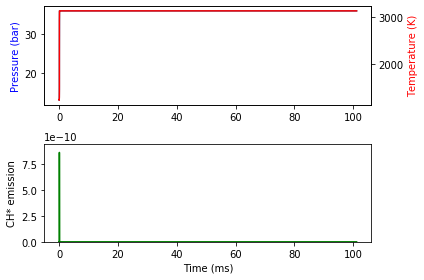

At 1250.0 K 13 bar, ignition delay time is 0.10746798973259435 ms


In [16]:
get_ignition_delay_n2(1000/.8, 13, 1, plot=True)
plt.rcParams['figure.figsize'] = [10, 8]

Reached end time 104.39 ms in 3523 steps
At 1538.4615384615383 K 13 bar, ignition delay time is 0.006853247523294802 ms
Reached end time 102.62 ms in 4910 steps
At 1407.035175879397 K 13 bar, ignition delay time is 0.02169623202306867 ms
Reached end time 101.66 ms in 4614 steps
At 1296.2962962962963 K 13 bar, ignition delay time is 0.06577962575972074 ms
Reached end time 100.97 ms in 4777 steps
At 1201.7167381974248 K 13 bar, ignition delay time is 0.17952956232489634 ms
Reached end time 100.02 ms in 4753 steps
At 1120.0 K 13 bar, ignition delay time is 0.42615678002218915 ms
Reached end time 101.35 ms in 5342 steps
At 1048.689138576779 K 13 bar, ignition delay time is 1.0002235364788357 ms
Reached end time 100.41 ms in 5774 steps
At 985.9154929577466 K 13 bar, ignition delay time is 2.5091119263140143 ms
Reached end time 100.17 ms in 6190 steps
At 930.232558139535 K 13 bar, ignition delay time is 6.041111265097542 ms
Reached end time 100.61 ms in 6445 steps
At 880.503144654088 K 13 ba

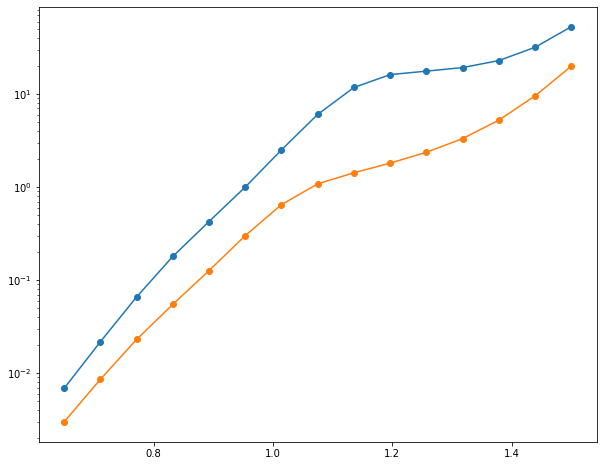

In [17]:
RMG_temperatures_dkm = 1000/np.linspace(0.65,1.5,15)
pressures_bar = [13, 50]
phi = 1.0

RMG_results = dict()

for P in pressures_bar:
    ignition_delay_times = np.zeros_like(RMG_temperatures_dkm)
    for i, T in enumerate(RMG_temperatures_dkm):
        ignition_delay_times[i] = get_ignition_delay_n2(T,P,phi)
    
    RMG_results[P] = ignition_delay_times 
    
    plt.semilogy(1000/RMG_temperatures_dkm, ignition_delay_times, 'o-', label='{0}'.format(P))


In [20]:
import pickle 


pickle_out = open('n-c10-dkm.pickle', 'wb')
pickle.dump(RMG_results, pickle_out)
pickle_out.close()

In [ ]:
# exp_nc10 = """0.659295    0.122155
# 0.679932    0.180035
# 0.686702    0.232651
# 0.691658    0.282004
# 0.697209    0.309786
# 0.715798    0.457250
# """


# ign_times = []
# temps = []


# for x in exp_nc10.splitlines():
#     temp, time = x.split()
#     ign_times.append(float(time))
#     temps.append(float(temp))
# temps = np.array(temps)
# ign_times = np.array(ign_times)

In [16]:
# extracted values of experimental ignition delay times for iso-octane in air from Pfhal et al @ 13 bar 
# using the docstrings


exp_nc10_13 = """0.771216    0.0869649
0.809216    0.191947
0.830035    0.264515
0.938927    0.785369
0.987919    1.73243
1.07350     2.82456
1.09187     3.81030
1.07099     1.92002
1.16876     2.75052
1.19687     3.05735
1.25302     2.45962
1.30917     2.11029
1.37027     2.44420
1.43262     3.43364
"""

exp_nc10_50 = """1.05546   0.338838
1.06769   0.331359
1.12629   0.239352
1.13114   0.197372
1.18007   0.218828
1.20089   0.253762
1.23270   0.269920
1.31961   0.402551
1.37116   0.884630
1.43976   1.43915
1.52559   3.90651
"""

ign_times13 = []
temps13 = []

ign_times50 = []
temps50 = []


for x in exp_nc10_13.splitlines():
    temp, time = x.split()
    ign_times13.append(float(time))
    temps13.append(float(temp))
temps13 = np.array(temps13)
ign_times13 = np.array(ign_times13)


for y in exp_nc10_50.splitlines():
    temps, times = y.split()
    ign_times50.append(float(times))
    temps50.append(float(temps))
temps50 = np.array(temps50)
ign_times50 = np.array(ign_times50)
    

{13: array([0.00724173, 0.00944335, 0.01230311, 0.01602565, 0.02089329,
       0.02728161, 0.03568915, 0.04677401, 0.06140938, 0.08070288,
       0.10612219, 0.1395819 , 0.1835768 , 0.24136223, 0.31715131]), 50: array([0.0031821 , 0.00407299, 0.0052161 , 0.0066927 , 0.00860996,
       0.01110941, 0.01438008, 0.01867224, 0.02431914, 0.03175915,
       0.04157284, 0.05451686, 0.07156374, 0.09394515, 0.1231905 ])}


<function matplotlib.pyplot.show(*args, **kw)>

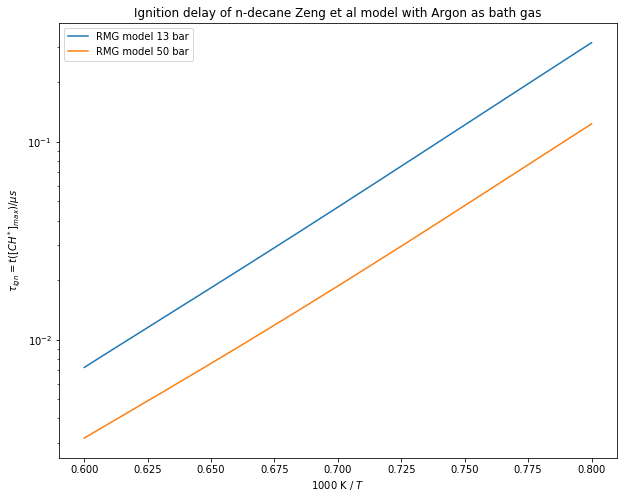

In [35]:
import pickle 


pickle_in = open('n-c10-zeng-model.pickle', 'rb')       
Zeng_results = pickle.load(pickle_in)

print(Zeng_results)

for key, val in Zeng_results.items():
    plt.semilogy(1000/RMG_temperatures_dkm, val, '-', label= 'RMG model {} bar'.format(key))
    
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane Zeng et al model with Argon as bath gas')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

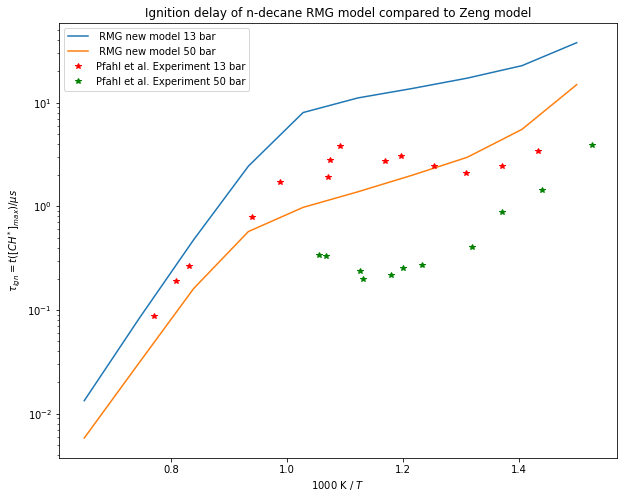

In [19]:


#plt.semilogy(temps, ign_times, 'g*', label='DC. Horning Experiment 1 atm')    


    
# for key, val in Zeng_results.items():
#     plt.semilogy(1000/RMG_temperatures_dkm, val, 'k--o', label= 'Zeng model {} bar'.format(key))
    


    
for P in pressures_bar:
    times = RMG_results[P]
    
    plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG new model {} bar'.format(P))    
    
    
    
plt.semilogy(temps13,ign_times13, 'r*', label='Pfahl et al. Experiment 13 bar')
plt.semilogy(temps50, ign_times50, 'g*', label='Pfahl et al. Experiment 50 bar')




plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane RMG model compared to Zeng model')
plt.show

In [ ]:





# # #plt.semilogy(temps, ign_times, 'g*', label='DC. Horning Experiment 1 atm')

# plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG model {} bar'.format(P))
# plt.legend(loc='best')
# plt.xlabel('1000 K / $T$')
# plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
# plt.rcParams['figure.figsize'] = [10, 8]
# plt.title('Ignition delay of n-decane detailed kinetic model compared to reduced model compared to ST experiment')
# plt.show


    


In [ ]:
# plt.semilogy(temps,ign_times, 'r*', label='DC Horning Experiment 1 atm')
# plt.semilogy(1000/RMG_temperatures, times, 'o-', label='RMG model {0} atm'.format(pressures_bar))
    
# plt.legend(loc='best')
# plt.xlabel("1000 K / temperature")
# #plt.xlim(0.6,0.8)
# plt.ylabel("Ignition delay time $\\tau$ (ms)")
# plt.title('RMG model of Ignition delay of n-Decane at $\phi$=1.0')
# plt.show()   
# plt.rcParams['figure.figsize'] = [10, 8]

<function matplotlib.pyplot.show(*args, **kw)>

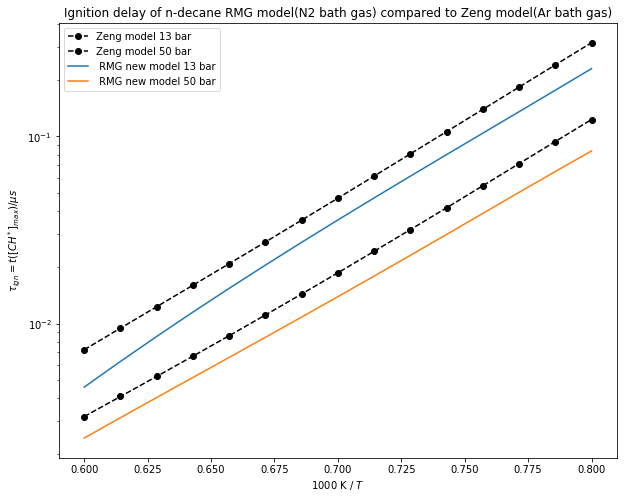

In [37]:
for key, val in Zeng_results.items():
    plt.semilogy(1000/RMG_temperatures_dkm, val, 'k--o', label= 'Zeng model {} bar'.format(key))
    


    
for P in pressures_bar:
    times = RMG_results[P]
    
    plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG new model {} bar'.format(P))  
    
    
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane RMG model(N2 bath gas) compared to Zeng model(Ar bath gas)')
plt.show    